In [114]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns

In [61]:
# bootstrap to compute sem of the median
# 参考(https://qiita.com/katsu1110/items/23b8a37ac400dd0eaad2)

# x dim: 0/ #of samples, 1/ #of data dims
def bootstrap(x, n_add_samples, n_repeat=1000):
    
    if n_add_samples < n_repeat:
        print("[n_added_samples] must be larger than [n_repeat]...")
        return
    
    ndim = np.shape(x)[1]
    increased_x = x
    
    for i in range(n_repeat):
        n_add = min([n_add_samples // n_repeat,  n_add_samples - i * (n_add_samples // n_repeat)])
        re = np.random.choice(len(x), len(x), replace=True)
        re_x = x[re, :]
        
        mean = np.mean(re_x, 0)
        cov = np.cov(re_x.T)
        
        increased_x = np.vstack([increased_x, np.random.multivariate_normal(mean, cov, n_add)])
        
    return increased_x


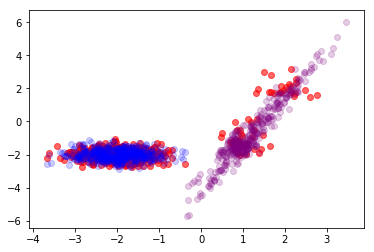

In [234]:
def build_toy_dataset(N, pi):
#   pi = np.array([0.1, 0.9])
  mus = [[2, 2], [-2, -2], [1, -1]]
  stds = [[0.1, 0.3], [0.3, 0.1], [0.1, 0.3]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
 
  return x
 
N = 500  # number of data points
ndim = 2  # dimensionality of data

x_train_n = build_toy_dataset(N, np.array([0.0, 1.0, 0]))
x_train_a = build_toy_dataset(round(N*0.01), np.array([0.5, 0, 0.5]))
x_train_a = bootstrap(x_train_a, round(N*0.99), 100)
x_test = build_toy_dataset(N, np.array([0.05, 0.9, 0.05]))

x_train = np.vstack([x_train, x_train_a])
y_train = np.vstack([np.ones((len(x_train_n), 1)), np.zeros((len(x_train_a), 1))]).reshape(-1, 1)

plt.scatter(x_test[:, 0], x_test[:, 1], color="red", alpha=0.6)
plt.scatter(x_train_n[:, 0], x_train_n[:, 1], color="blue", alpha=0.2)
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], color="purple", alpha=0.2)

plt.show()

In [319]:
dis_func = lambda a, b, A: np.diag(np.dot(np.dot((a - b), A), (a - b).T))
def get_kNNs(a, b, k, A):
    dis_lst = dis_func(a, b, A)
    dis_lst.flags.writeable = True
    kNNs_ind = np.zeros(k)
    for k_i in range(k):
        kNNs_ind[k_i] = np.argmax(dis_lst)
        dis_lst[int(kNNs_ind[k_i])] = 0
    return kNNs_ind

In [322]:
# パラメータの初期化
a_rate = 0.1  # 誤報率
k =  round(N * (1-a_rate)) # 近傍数
eta = 0.1  # ステップ幅
mu = 0.5  # 同一ラベルの密集度合と条件が破られている度合の早退的な重み（通常0.5）
n_train = len(x_train)

A = np.eye(2)

def get_l(x, n, j, A):
    ind_1_a = np.prod(np.array([x != x[n, :]]), 1) == 1
    ind_1_b = np.prod(np.array([x != x[j, :]]), 1) == 1
    ind_1 = np.logical_and(ind_1_a, ind_1_b)
    ind_2 = 1 + dis_func(x[n, :], x[j, :], A) - dis_func(x[n, :], x, A).reshape(-1, 1) > 0
    ind = np.logical_and(ind_1, ind_2)
    ind = ind.reshape(-1)
    return x[ind, :]

C = lambda i, j, N: np.dot((np.eye(1, M=N, k=i) - np.eye(1, M=N, k=j)).T, (np.eye(1, M=N, k=i) - np.eye(1, M=N, k=j)))

for i in range(1000):
    C_a = lambda n, j: (1-mu) * C(n, j, ndim)
    C_b = lambda n, j: mu * np.sum(C(n, j, ndim) - C(n, get_l(x_train, n, j, A)))
    C_c  = 0
    for n in range(len(x_train)):
        tmp_b = np.array([np.ones(len(x_train))==1]).reshape(-1)
        tmp_b[n] = False
        tmp_x = x_train[tmp_b, :]
        N_n = get_kNNs(tmp_x, x_train[n], k, A)
        for j in N_n:
            C_c = C_c + C_a(n, int(j)) + C_b(n, int(j))
    delta_A = (1/n_train) * np.dot(np.dot(X.T, C_c), X)
    A = A - eta * delt_A
    edig, evec = scipy.linalg.eigh(A)
    A = np.dot(np.dot(evec, np.diag(abs(edig))), evec.T)
    

0
[1940. 1015. 1548. 1639. 2115. 1616. 1703. 1887. 1644. 1546. 1986. 1911.
 1395. 2117. 2036. 1605. 2011. 1941. 1317. 1345. 1533. 1426. 1791. 1520.
 1360. 1870. 1408. 1726. 1455. 1623. 1424. 1859. 1125. 1092. 1651. 1886.
 1589. 1563. 1363. 1013. 1358. 1087. 2097. 1849. 1990. 1652. 1814. 1452.
 1410. 1404. 1562. 1440. 1689. 1460. 1614. 1560.  968. 1496. 1188. 1504.
 1429. 1278. 1918. 2060. 1279. 2091. 1714. 1609. 1474. 1607. 1598. 1588.
 1889. 1299. 1622. 1698. 1604. 1808. 1507. 1659. 1403. 1365. 1596. 1678.
 1830. 1552. 1356. 1641. 1348.  945. 1482. 1707. 1734. 1906. 1180. 1374.
 1372. 1370. 1564. 1344. 1593. 1857. 1549. 1694. 1458. 1582. 1650. 1606.
 1688. 1513. 1555. 1441. 1540. 1539. 1608. 1783. 1312. 1592. 1869. 1346.
 2087. 1786. 1633. 1741. 1645. 1536. 2043. 1591. 1325.  965. 2010. 1858.
 1454. 1475. 1868. 1476. 1490. 1129. 1706. 1637. 1477. 1661. 1498. 1914.
 1635. 1309. 1708. 2105. 1412. 1575. 1812. 1709. 1511. 2035. 1938. 1686.
 1438. 1448. 1595. 1570. 1817. 1818. 1666. 1532. 

ValueError: Input must be 1- or 2-d.

In [312]:
[np.sum(x_train != x_train[1, :], 1) < ndim] * [np.sum(x_train != x_train[1, :], 1) < ndim]

TypeError: can't multiply sequence by non-int of type 'list'

In [56]:
np.shape(np.random.multivariate_normal(mean, cov, 5000))

(5000, 2)

In [216]:
b=np.array([[5,3.5],[3,4]])
print(b)

[[5.  3.5]
 [3.  4. ]]


In [217]:
edig, evec = scipy.linalg.eigh(b)

In [218]:
print('A evec =', np.dot(b, np.linalg.inv(evec)))
print('evec edig=', np.dot(evec, np.diag(edig)))

A evec = [[ 0.56130454 -6.07741205]
 [-1.11295524 -4.87455953]]
evec edig= [[ 0.94281453 -5.7542246 ]
 [-1.11295524 -4.87455953]]


In [228]:
a = np.dot(np.dot(edig, np.diag(evec)), edig.T)
print(edig)

[1.45861873 7.54138127]


In [230]:
np.dot(np.dot(evec, np.diag(abs(edig))), evec.T)

array([[5., 3.],
       [3., 4.]])

In [214]:
print(evec)
print(edig)

[[ 0.6463749  -0.76301998]
 [-0.76301998 -0.6463749 ]]
[1.45861873 7.54138127]


In [103]:
w, v = np.linalg.eig(b)

In [110]:
np.dot(np.dot(v, i), v.T)

array([[-0.58883843,  1.14070919],
       [ 1.63330137, -2.33990804]])

In [252]:
a = x_train[n]
b = x_train[j]
np.diag(np.shape(np.dot(np.dot((a - b), A), (a - b).T)))

array([], shape=(0, 0), dtype=float64)

In [261]:
np.arange(5)[1:2]

array([1])

In [277]:
a = np.hstack([np.arange(5), np.arange(8)])
a = np.unique(a)
sorted(a, reverse=True)[1:3]

[6, 5]

In [279]:
np.ones(5)==1

array([ True,  True,  True,  True,  True])